In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

Функция генерации точек по функции окружности с добавлением шума

In [2]:
def circle_data_gen(x0: float, y0: float, r: float, points_num: int, valid_percent: float, random_scale: float):
  angle = np.linspace(0, 2 * math.pi, int(points_num * valid_percent))
  angle2 = np.linspace(0, 2 * math.pi, int(points_num * (1-valid_percent)))

  inliners_points = [[x0 + r * math.cos(t) + np.random.normal(0, random_scale / 10), y0 + r * math.sin(t) + np.random.normal(0, random_scale / 10)] for t in angle]
  outliners_points = [[x0 + r * math.cos(t) + np.random.normal(0, random_scale), y0 + r * math.sin(t) + np.random.normal(0, random_scale)] for t in angle]
  return np.concatenate((inliners_points, outliners_points))

Генерация точек и вывод графика

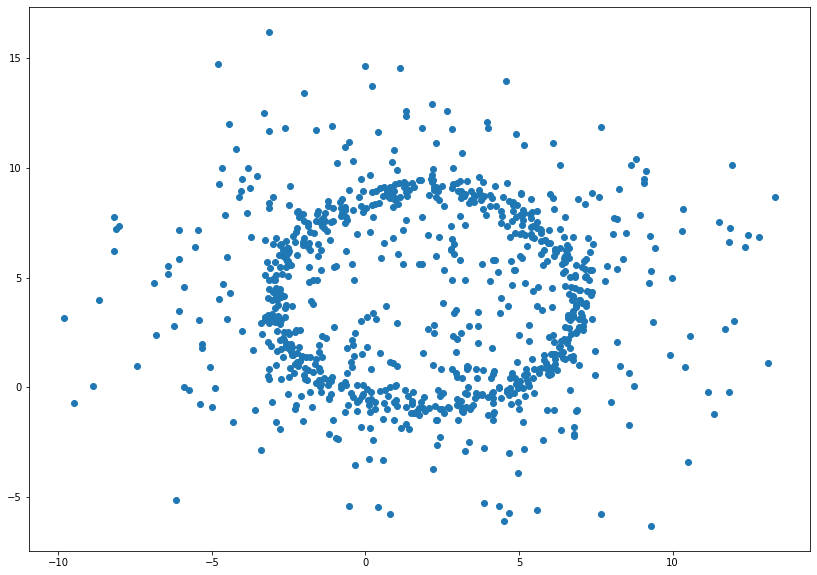

In [3]:
data = circle_data_gen(2, 4, 5, 500, 0.9, 3)

plt.figure(figsize=(14, 10))
plt.scatter(data[:, 0], data[:, 1])

Функция получения центра окржности и радиуса по заданным 3 точкам

In [4]:
def get_circle(p1, p2, p3):
  c = (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2
  a = (p2[0] - p3[0])**2 + (p2[1] - p3[1])**2
  b = (p3[0] - p1[0])**2 + (p3[1] - p1[1])**2

  s = 2 * (a*b + b*c + c*a) - (a*a + b*b + c*c)

  p0 = np.array([((a*(b+c-a)*p1[0]) + (b*(c+a-b)*p2[0]) + (c*(a+b-c)*p3[0]))/s,
                 ((a*(b+c-a)*p1[1]) + (b*(c+a-b)*p2[1]) + (c*(a+b-c)*p3[1]))/s])

  ar = a**0.5
  br = b**0.5
  cr = c**0.5

  r = ar*br*cr / ((ar+br+cr) * (-ar+br+cr) * (ar-br+cr) * (ar+br-cr))**0.5

  return p0, r

Функция, реализуящая метод RANSAC для функции окружности ${R^2 = (x-x_0)^2 + (y-y_0)^2}$

In [5]:
def circle_ransac(data, iter_number=100, eps=0.05, min_inliners=10):
  # выполнение итераций указанное количество раз
  for i in range(iter_number):
    inliners = []
    error = 0
    best_score = float('inf')
  
    # выбираем индексы 2-х точек из массива
    indexes = np.random.choice(data.shape[0], 3, replace=False)
    # print(indexes)

    # получаем координаты выбранных точек
    p1, p2, p3 = data[indexes, :]

    # получение центра окружности и радиуса
    try:
      p0, r = get_circle(p1, p2, p3)
    except Exception as e:
      print("Could not generate Circle model. Error=%s \n" % (str(e)))
      continue

    # пробегаемся по остальным точкам
    for p in data:
      if p in data[indexes, :]:
        continue

      # расситываем разницу в радиусах
      p_r = math.sqrt((p[0]-p0[0])**2 + (p[1]-p0[1])**2)
      diff_r = math.fabs(p_r - r)

      if diff_r > eps:
        continue

      inliners.append(p_r)
      error += diff_r

    if len(inliners) < min_inliners:
      continue
    
    # если суммарная ошибка меньше лучшего значения - обновляем данные
    if error < best_score:
        best_score = error
        best_params = p0, r
        best_points = p1, p2, p3

        error = 0

  return best_params, best_points

Применение функции RANSAC для функции окружности

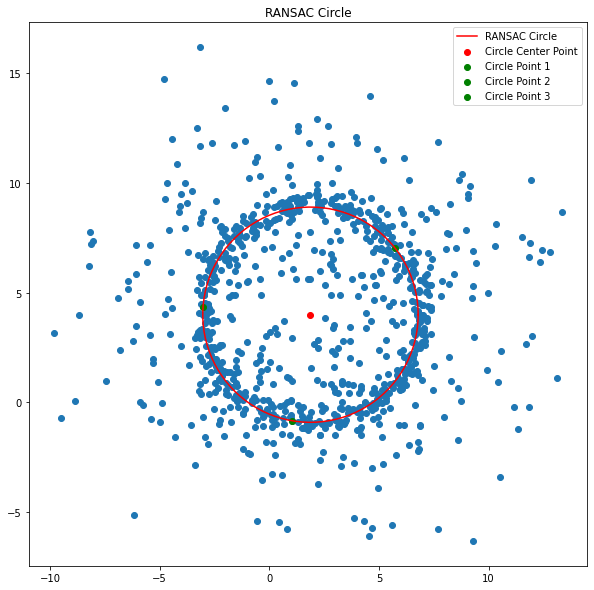

In [6]:
(p0, r),  (p1, p2, p3) = circle_ransac(data=data, iter_number=100, eps=0.05, min_inliners=50)

angle = np.linspace(0, 2 * math.pi, 100)
scatter_points = np.array([[p0[0] + r * math.cos(t), p0[1] + r * math.sin(t)] for t in angle])

plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(p0[0], p0[1], label='Circle Center Point', color='red')
plt.scatter(p1[0], p1[1], label='Circle Point 1', color='green')
plt.scatter(p2[0], p2[1], label='Circle Point 2', color='green')
plt.scatter(p3[0], p3[1], label='Circle Point 3', color='green')
plt.plot(scatter_points.T[0], scatter_points.T[1], label='RANSAC Circle', color='red')

plt.legend()
plt.title('RANSAC Circle')
plt.savefig('RANSAC Circle.png')